# Прогнозирование оттока клиентов

## План работы

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.\
Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов:
   - через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия»)
   - оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
1. Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity)
2. Выделенная линия технической поддержки (TechSupport)
3. Облачное хранилище файлов для резервного копирования данных (OnlineBackup)
4. Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Цель проекта:**\
Разработать модель наиболее точно отвечающую на вопрос "откажется ли конкретный клиент от услуг или нет".

In [97]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import warnings
import math
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
import time
import re
import phik

In [98]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [99]:
contract_new_local = 'C:/Users/ah371/.vscode/проект/contract_new.csv'
internet_new_local = 'C:/Users/ah371/.vscode/проект/internet_new.csv'
personal_new_local = 'C:/Users/ah371/.vscode/проект/personal_new.csv'
phone_new_local = 'C:/Users/ah371/.vscode/проект/phone_new.csv'

In [100]:
contract_new_std = '/datasets/contract_new.csv'
internet_new_std = '/datasets/internet_new.csv'
personal_new_std = '/datasets/personal_new.csv'
phone_new_std = '/datasets/phone_new.csv'

In [101]:
if os.path.exists(contract_new_local):
    contract_new = pd.read_csv(contract_new_local)
elif os.path.exists(contract_new_std):
    contract_new = pd.read_csv(contract_new_std)
else:
    print('Ошибка пути')

if os.path.exists(internet_new_local):
    internet_new = pd.read_csv(internet_new_local)
elif os.path.exists(internet_new_std):
    internet_new = pd.read_csv(internet_new_std)
else:
    print('Ошибка пути')

if os.path.exists(personal_new_local):
    personal_new = pd.read_csv(personal_new_local)
elif os.path.exists(personal_new_std):
    personal_new = pd.read_csv(personal_new_std)
else:
    print('Ошибка пути')

if os.path.exists(phone_new_local):
    phone_new = pd.read_csv(phone_new_local)
elif os.path.exists(phone_new_std):
    phone_new = pd.read_csv(phone_new_std)
else:
    print('Ошибка пути')

In [102]:
contract_new.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
676,2324-AALNO,2016-02-01,No,One year,No,Bank transfer (automatic),24.55,1237.32
3627,3243-ZHOHY,2018-10-01,No,One year,No,Mailed check,20.10,321.6
1668,9659-QEQSY,2016-05-01,No,Month-to-month,Yes,Electronic check,115.65,5568.55


In [103]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [104]:
contract_new.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Пропусков нет. В столбце общие расходы явно присутствуют данные не соответствующего типа.

In [105]:
internet_new.sample(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4014,6408-OTUBZ,Fiber optic,Yes,Yes,Yes,Yes,Yes,No
3473,6161-UUUTA,Fiber optic,No,No,No,No,Yes,No
932,6270-OMFIW,Fiber optic,No,Yes,No,No,Yes,Yes


In [106]:
internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Категориальные данные. В основном бинарные. Количество строк меньше, чем в предыдущем датафрейме.

In [107]:
personal_new.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
1349,2625-TRCZQ,Female,0,Yes,No
2265,1583-IHQZE,Male,0,No,No
6850,0531-XBKMM,Male,0,No,Yes


In [108]:
personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Все данный категориальные, бинарные.

In [109]:
phone_new.sample(3)

,customerID,MultipleLines
5119,7452-FOLON,Yes
686,0030-FNXPP,No
1534,9225-BZLNZ,Yes


In [110]:
phone_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Один бинарный признак. Строк также меньше. Не все пользуются интернетом. Не все пользуются телефоном.

**План проекта**
1. Предобработка данных:
   - Объединить в один датафрейм
   - Привести названия столбцов к приличному виду
   - привести к соответствующим типам данных нужные столбцы
   - Работа с пропусками
   - Работа с аномальными даными, удаление выбросов
2. Ислледовательский анализ
   - Дать характеристику для группы продолжающих пользоваться услугами и группы отказавшихся от услуг.
   - Проверить корреляцию признаков
3. Подготовка данных для обучения моделей
   - Создание новых необходимых признаков
   - Удаление лишних признаков
   - Разбиение на тренировочную и тестовую выборки
   - Подготовка данных для линейных моделей
4. Обучение моделей
   - логистическая регрессия
   - случайный лес
   - бустинговая модель (выбор бустинговой модели)
   - выбор лучшей модели
5. Проверка лучшей модели, вывод.
   - проверка на тестовой выборке
   - вывод

## Основная чать проекта

### Предобработка данных

In [111]:
# Информация о договорах актуальна на 1 февраля 2020.
date = '2020-02-01'
RANDOM = 250923

In [112]:
# Объединим все файлы в один по столбцу customerID
data_full = pd.merge(contract_new, personal_new, how='outer', on='customerID')

In [113]:
data_full = pd.merge(data_full, internet_new, how='outer', on='customerID')

In [114]:
data_full = pd.merge(data_full, phone_new, how='outer', on='customerID')

In [115]:
data_full.set_index('customerID', inplace=True)

In [116]:
data_full.sample(3)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
8046-DNVTL,2014-12-01,2017-07-01,Two year,Yes,Credit card (automatic),38.60,1292.33,Male,0,Yes,No,DSL,Yes,Yes,No,Yes,No,No,NaN
8016-ZMGMO,2014-08-01,No,One year,Yes,Bank transfer (automatic),70.85,4769.62,Female,1,Yes,No,DSL,No,Yes,Yes,No,Yes,No,Yes
2272-JKMSI,2014-12-01,No,One year,Yes,Electronic check,110.80,6869.6,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes


In [117]:
# Приведение названий столбцов к нижнему регистру и змейке
data_full.columns = [re.sub(r'([a-z])([A-Z])', r'\1_\2', i).lower() for i in data_full.columns]

In [118]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv  

In [119]:
# приведем дату начала использования услуг к нужному формату
data_full['begin_date'] = pd.to_datetime(data_full['begin_date'], format='%Y-%m-%d')

In [120]:
# создадим новый признак: продолжает пользоваться услугами (будет 0) или отказался (будет 1)
def new_f(end_date):
    if end_date == 'No':
        return 0
    else:
        return 1
data_full['refuse_the_service'] = data_full['end_date'].apply(new_f)

In [121]:
data_full['refuse_the_service'].value_counts()

refuse_the_service
0    5942
1    1101
Name: count, dtype: int64

Сразу можно сказать, что это наш **целевой признак**. Виден дисбаланс классов.

In [122]:
# заменим в столбце end_date No на последнюю актуальную дату по ТЗ.
data_full['end_date'] = data_full['end_date'].replace('No', date)

In [123]:
# приведем столбец end_date к нужному формату
data_full['end_date'] = pd.to_datetime(data_full['end_date'], format='%Y-%m-%d')

Заполним пропуски. По логике вещей все пропуски можно заменить на NO. т.к. кто-то не пользуется интернетом, кто-то телефоном.\
Проверим нет ли таких строк где пусто и для интернета и для телефона.

In [124]:
subset = data_full.loc[(data_full['multiple_lines'].isna()) & (data_full['streaming_movies'].isna())]

In [125]:
subset

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,refuse_the_service
customerID,,,,,,,,,,,,,,,,,,,,


Таких нет, соответственно предположение правильное.\
Проверим везде ли бинарные данные.

In [126]:
li = ['internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']

for i in li:
    print(data_full[i].value_counts())

internet_service
Fiber optic    3096
DSL            2421
Name: count, dtype: int64
online_security
No     3498
Yes    2019
Name: count, dtype: int64
online_backup
No     3088
Yes    2429
Name: count, dtype: int64
device_protection
No     3095
Yes    2422
Name: count, dtype: int64
tech_support
No     3473
Yes    2044
Name: count, dtype: int64
streaming_tv
No     2810
Yes    2707
Name: count, dtype: int64
streaming_movies
No     2785
Yes    2732
Name: count, dtype: int64
multiple_lines
No     3390
Yes    2971
Name: count, dtype: int64


In [127]:
# теперь со спокойной душой заполним пропуски словом 'No'
data_full = data_full.fillna('No')

In [128]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   begin_date          7043 non-null   datetime64[ns]
 1   end_date            7043 non-null   datetime64[ns]
 2   type                7043 non-null   object        
 3   paperless_billing   7043 non-null   object        
 4   payment_method      7043 non-null   object        
 5   monthly_charges     7043 non-null   float64       
 6   total_charges       7043 non-null   object        
 7   gender              7043 non-null   object        
 8   senior_citizen      7043 non-null   int64         
 9   partner             7043 non-null   object        
 10  dependents          7043 non-null   object        
 11  internet_service    7043 non-null   object        
 12  online_security     7043 non-null   object        
 13  online_backup       7043 non-null   ob

In [129]:
li_2 = list(data_full.columns)
li_2 = list(filter(lambda x: x not in ['monthly_charges', 'total_charges', 'customer_id', 'begin_date', 'end_date'], li_2))

In [130]:
for i in li_2:
    print(data_full[i].value_counts())

type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64
paperless_billing
Yes    4171
No     2872
Name: count, dtype: int64
payment_method
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64
gender
Male      3555
Female    3488
Name: count, dtype: int64
senior_citizen
0    5901
1    1142
Name: count, dtype: int64
partner
No     3641
Yes    3402
Name: count, dtype: int64
dependents
No     4933
Yes    2110
Name: count, dtype: int64
internet_service
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64
online_security
No     5024
Yes    2019
Name: count, dtype: int64
online_backup
No     4614
Yes    2429
Name: count, dtype: int64
device_protection
No     4621
Yes    2422
Name: count, dtype: int64
tech_support
No     4999
Yes    2044
Name: count, dtype: int64
streaming_tv
No     4336
Yes    2707
Name: count

Со столбцом total_charges что-то не так. Там есть ячейки с несоответствующим типом данных.

In [131]:
data_full['total_charges'].sort_values().value_counts()

total_charges
          11
20.45      6
101.0      5
40.1       4
732.6      4
          ..
2432.7     1
2432.3     1
243.97     1
243.88     1
999.9      1
Name: count, Length: 6658, dtype: int64

11 "пустых" ячеек\
Переведем тип в float, все некорректные заменин на NaN

In [132]:
data_full['total_charges'] = pd.to_numeric(data_full['total_charges'], errors='coerce')
data_full['total_charges'].isna().sum()

11

Есть подозрение, что это "свежие клиенты". Посмотрим что у них в столбце про месячные траты.

In [133]:
data_full[data_full['total_charges'].isna()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,refuse_the_service
customerID,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,No,No,No,No,No,No,No,No,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,0


In [134]:
# NaN заменим на значения из месячных трат
data_full.loc[data_full['total_charges'].isna(), 'total_charges'] = data_full['monthly_charges']

In [135]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   begin_date          7043 non-null   datetime64[ns]
 1   end_date            7043 non-null   datetime64[ns]
 2   type                7043 non-null   object        
 3   paperless_billing   7043 non-null   object        
 4   payment_method      7043 non-null   object        
 5   monthly_charges     7043 non-null   float64       
 6   total_charges       7043 non-null   float64       
 7   gender              7043 non-null   object        
 8   senior_citizen      7043 non-null   int64         
 9   partner             7043 non-null   object        
 10  dependents          7043 non-null   object        
 11  internet_service    7043 non-null   object        
 12  online_security     7043 non-null   object        
 13  online_backup       7043 non-null   ob

In [136]:
# посмотрим на всякий случай на наличие дубликатов
data_full.duplicated().sum()

4

In [137]:
# проверим нет ли ошибок в датах
print(data_full['begin_date'].min())
print(data_full['begin_date'].max())

2013-10-01 00:00:00
2020-02-01 00:00:00


In [138]:
print(data_full['end_date'].min())
print(data_full['end_date'].max())

2014-06-01 00:00:00
2020-02-01 00:00:00


Даты выглядят адекватно.

Добавим новые признаки.

In [139]:
# Длительность пользования услугами
data_full['duration'] = (data_full['end_date'] - data_full['begin_date']).dt.days
data_full

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,refuse_the_service,duration
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,2035.20,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0,730
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.40,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0,2191
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.60,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No,0,337


Еще идея с количеством подключенных дополнительных услуг в качестве нового признака.

In [140]:
# Столбец с количеством подключенных услуг
col = ['online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']
data_full['additional_services'] = (data_full[col] == 'Yes').sum(axis=1)

Данные объединены, очищены от пропусков, приведены к соответствующему типу данных. Добавлены два новых признака длительность пользования услуг, количество подключенных дополнительных услуг. Также добавлен целевой признак - отказ от услуг.

### **Исследовательский анализ**

In [141]:
data_full.head(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,refuse_the_service,duration,additional_services
customerID,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31,1
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036,2
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123,2
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371,3
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153,0
9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0,337,4
1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0,671,3
6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,No,0,306,1
7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0,945,5


Посмотрим кто вообще пользуется услугами компании.

In [142]:
data_full.describe()

,begin_date,end_date,monthly_charges,total_charges,senior_citizen,refuse_the_service,duration,additional_services
count,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2019-10-16 02:22:05.912253440,64.761692,2115.377573,0.162147,0.156325,898.555729,2.459747
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,19.050000,0.000000,0.000000,0.000000,0.000000
25%,2015-06-01 00:00:00,2020-02-01 00:00:00,35.500000,436.750000,0.000000,0.000000,276.000000,1.000000
50%,2017-09-01 00:00:00,2020-02-01 00:00:00,70.350000,1343.350000,0.000000,0.000000,761.000000,2.000000
75%,2019-04-01 00:00:00,2020-02-01 00:00:00,89.850000,3236.690000,0.000000,0.000000,1461.000000,4.000000
max,2020-02-01 00:00:00,2020-02-01 00:00:00,118.750000,9221.380000,1.000000,1.000000,2314.000000,7.000000
std,NaN,NaN,30.090047,2112.678861,0.368612,0.363189,683.130510,2.045539


Средние месячные траты состовляют почти 65 у.е. Средняя продолжительность иполльзования услуг около 900 дней. В среднем 2-3 дополнительные услуги. Только 16% пенсионеры. Доля ушедших 15,6%.

Посмотрим на категориальные данные

In [143]:
data_full.columns

Index(['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'gender', 'senior_citizen',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines', 'refuse_the_service', 'duration',
       'additional_services'],
      dtype='object')

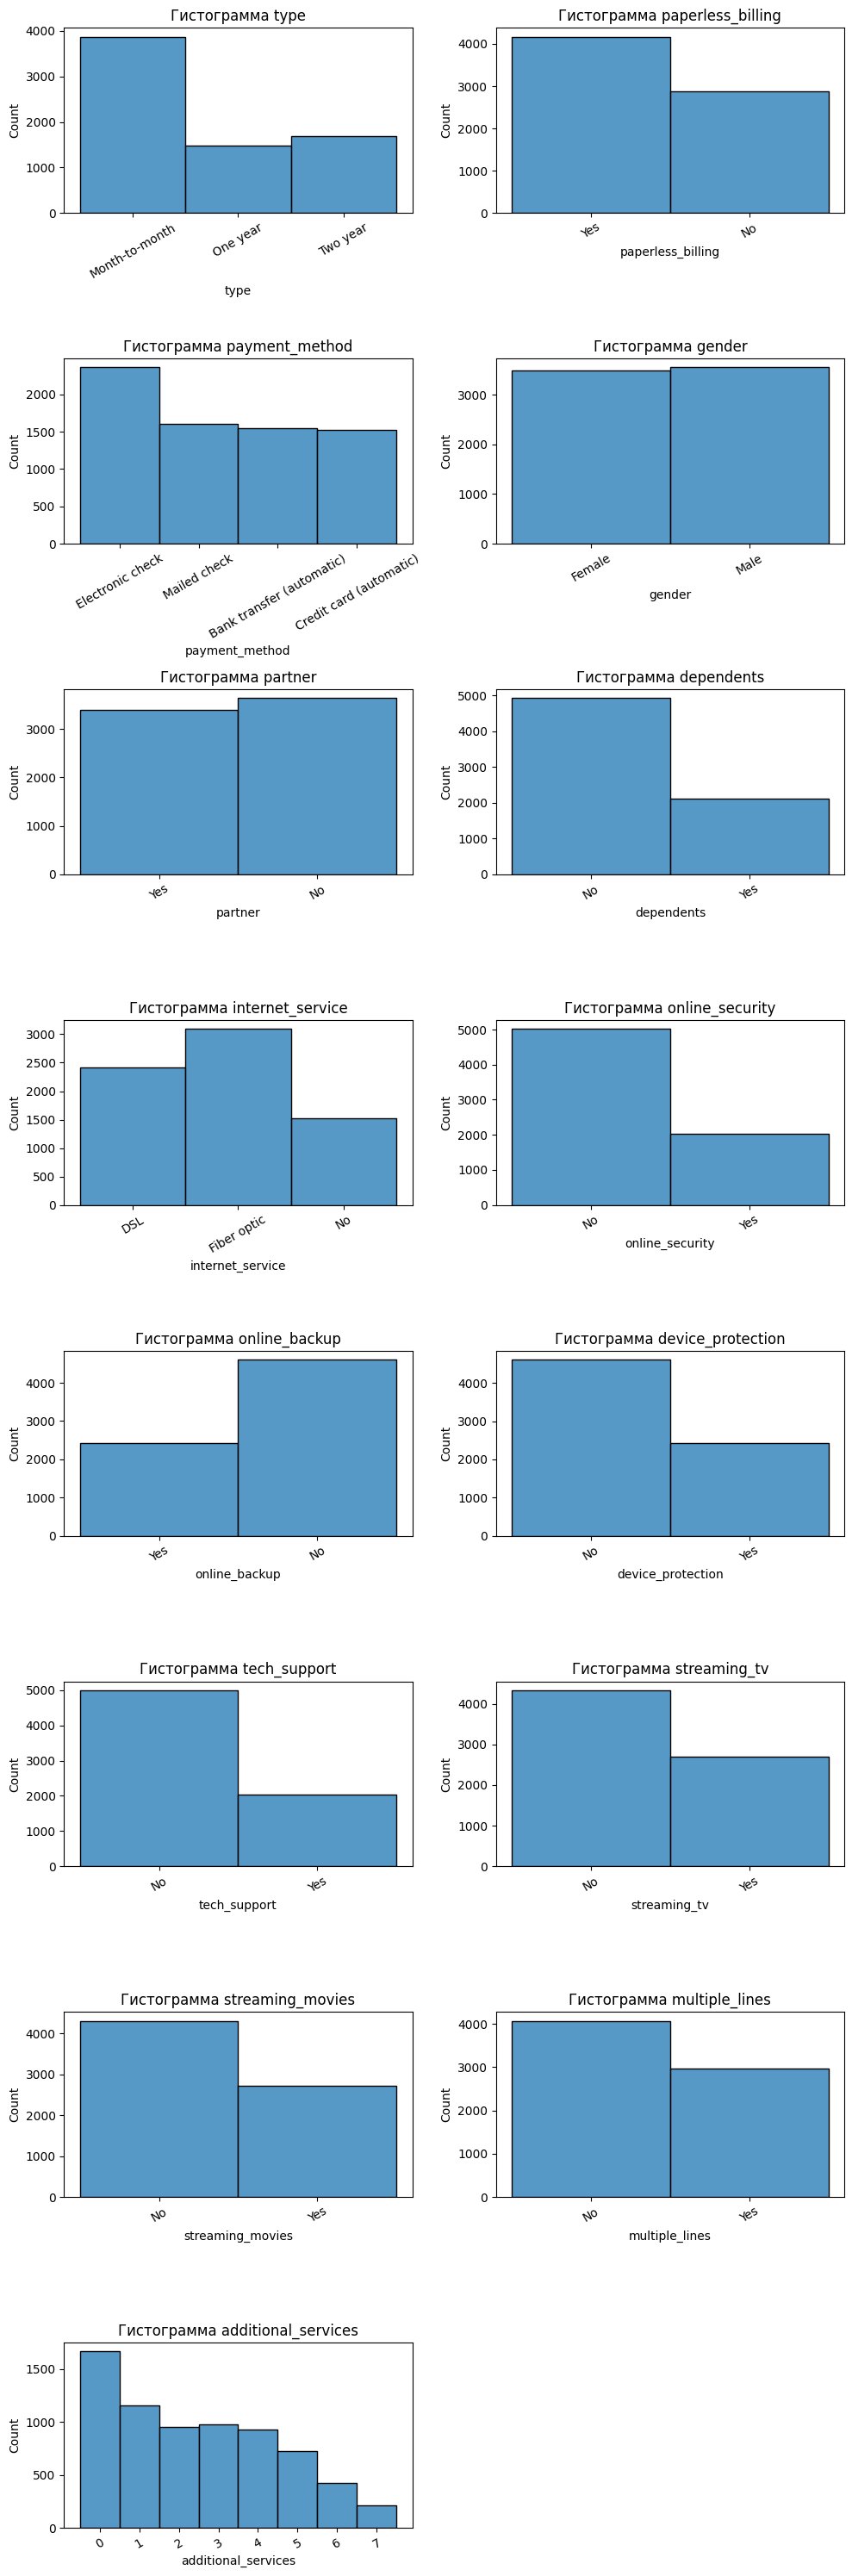

In [144]:
col_for_sns = ['type', 'paperless_billing',
       'payment_method', 'gender', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines', 'additional_services']

total_cols = len(col_for_sns)
cols = 2
rows = math.ceil(total_cols / cols)

plt.figure(figsize=(10, 30))
for i, column in enumerate(col_for_sns, start=1):
    plt.subplot(rows, cols, i)
    sns.histplot(data_full[column], discrete=True)
    plt.title(f'Гистограмма {column}')
    plt.xticks(rotation=30)
    
plt.tight_layout()
plt.show()

Примерно одинаковое количество мужчин и женщин, состоящих в браке и нет. В основном без иждиенцев. Предпочитаемый тип оплаты  помесячный, электронным чеком.

Посмотрим как отличаются люди продолжающие пользоваться услугами и те кто отказался.

In [145]:
comparison = ['monthly_charges', 'total_charges',
       'duration', 'additional_services', 'senior_citizen', 'refuse_the_service']
result_df = data_full[comparison].groupby('refuse_the_service').mean()
result_df.T

refuse_the_service,0,1
monthly_charges,62.763455,75.546004
total_charges,2067.943095,2371.377275
duration,893.681084,924.863760
additional_services,2.277516,3.443233
senior_citizen,0.153147,0.210718


Интересно, что отказавшиеся в итоге от услуг в среднем имели большие месячные траты, большее количество дополнительных услуг, среди них было больше пенсионеров и они в среднем дольше пользовались услугами.

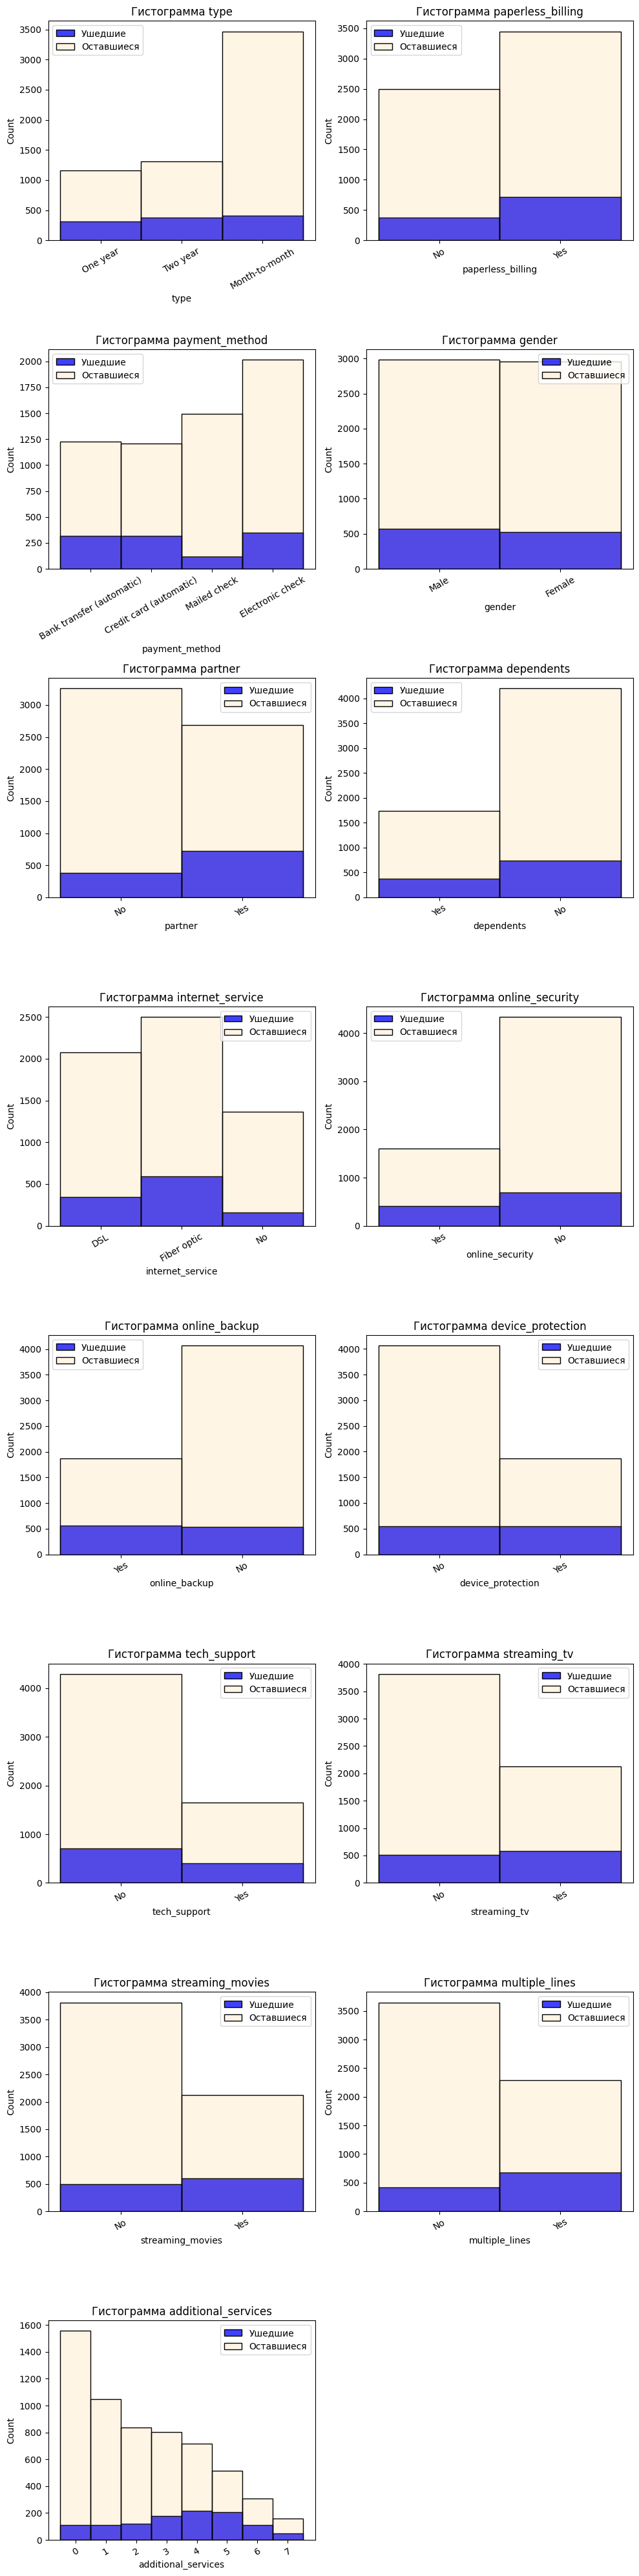

In [146]:
col_for_sns = ['type', 'paperless_billing',
       'payment_method', 'gender', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines', 'additional_services']

total_cols = len(col_for_sns)
cols = 2
rows = math.ceil(total_cols / cols)

plt.figure(figsize=(10, 40))
for i, column in enumerate(col_for_sns, start=1):
    plt.subplot(rows, cols, i)
    sns.histplot(data_full[data_full['refuse_the_service'] == 1][column], discrete=True, color='blue', label='Ушедшие')
    sns.histplot(data_full[data_full['refuse_the_service'] == 0][column], discrete=True, color='orange', label='Оставшиеся', alpha=0.1)
    plt.title(f'Гистограмма {column}')
    plt.xticks(rotation=30)
    plt.legend()
    
plt.tight_layout()
plt.show()

In [147]:
data_full['refuse_the_service'].value_counts()

refuse_the_service
0    5942
1    1101
Name: count, dtype: int64

Можно отметить, что в группах сохраняется примерно одинаковое соотношение женщин и мужчин, предпочтение безналичному расчету и преимущественно отсутствие иждивенцов.\
В отличие от оставшихся у ушедших нет сильного превалирования помесячной оплаты и типа оплаты - электронного чека. У ушедших более вероятно есть супруг, и количество используемых дополнительных услуг больше.

Посмотрим на корреляцию данных

In [158]:
phik_matrix = data_full.drop(['refuse_the_service'], axis=1).phik_matrix()
phik_matrix

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'duration', 'additional_services']


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration,additional_services
begin_date,1.000000,0.548313,0.766249,0.081447,0.456389,0.421886,0.773659,0.011268,0.050862,0.473514,0.208564,0.192197,0.403560,0.445583,0.456002,0.399506,0.359784,0.371863,0.428109,0.978521,0.587428
end_date,0.548313,1.000000,0.285429,0.062936,0.169262,0.173493,0.216439,0.018274,0.090502,0.177492,0.055518,0.117099,0.129611,0.203659,0.197691,0.112812,0.164794,0.177561,0.209337,0.396342,0.263940
type,0.766249,0.285429,1.000000,0.106860,0.277462,0.388444,0.468471,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.634155,0.456149
paperless_billing,0.081447,0.062936,0.106860,1.000000,0.370495,0.467812,0.203144,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.026799,0.342467
payment_method,0.456389,0.169262,0.277462,0.370495,1.000000,0.399526,0.335175,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.350964,0.463011
monthly_charges,0.421886,0.173493,0.388444,0.467812,0.399526,1.000000,0.711029,0.008175,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883,0.387727,0.781350
total_charges,0.773659,0.216439,0.468471,0.203144,0.335175,0.711029,1.000000,0.000000,0.137707,0.381042,0.082134,0.489674,0.521522,0.622643,0.641455,0.549866,0.642144,0.644671,0.572584,0.847414,0.621581
gender,0.011268,0.018274,0.000000,0.000000,0.000000,0.008175,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.050862,0.090502,0.086231,0.242133,0.292725,0.304985,0.137707,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.063315,0.181336
partner,0.473514,0.177492,0.179736,0.013218,0.243008,0.203545,0.381042,0.000000,0.016992,1.000000,0.652122,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.220101,0.453688,0.303770


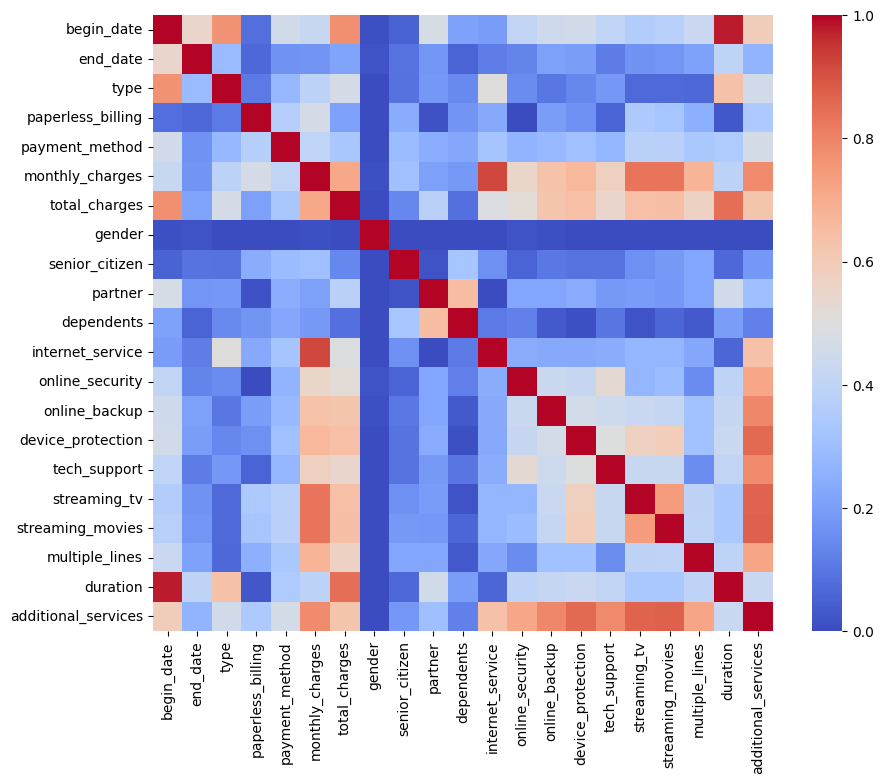

In [164]:
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, cmap='coolwarm')
plt.show()

Сильная корреляция у продолжительности пользования услугами и датой начала. В любом случае перед подготовкой данных для моделей дата начала будет удалена.\
Также сильная корреляция у продолжительности пользования услуг и общими тратами, что логично, чем дольше человек пользуется услугами, тем больше он в сумме потратит.\
Месячная плата имеет корреляции с несколькими признаками.\
Количество дополнительных услуг имеет сильные корреляции с каждой доп услугой. Боюсь что признак бесполезен для моделей, будет удален.

Поробуем все таки добавить признак группы величины месячной платы.

<Axes: xlabel='monthly_charges', ylabel='Count'>

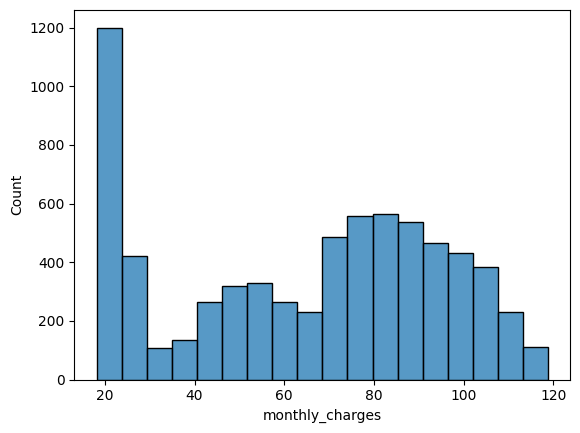

In [54]:
sns.histplot(data_full['monthly_charges'], bins=18)

In [55]:
data_full['monthly_charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

In [56]:
# границы для групп выбраны примерно исходя из графика и квартилей
bins = [0, 30, 65, 120]
labels = [1, 2, 3]
data_full['monthly_charges_gr'] = pd.cut(data_full['monthly_charges'], bins=bins, labels=labels)

In [57]:
phik_matrix_2 = data_full.drop(['refuse_the_service', 'monthly_charges',
                                'begin_date', 'end_date', 'total_charges', 'additional_services'], axis=1).phik_matrix()
phik_matrix_2

interval columns not set, guessing: ['senior_citizen', 'duration']


,type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration,monthly_charges_gr
type,1.000000,0.106860,0.277462,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.634155,0.405774
paperless_billing,0.106860,1.000000,0.370495,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.026799,0.212286
payment_method,0.277462,0.370495,1.000000,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.350964,0.295941
gender,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.086231,0.242133,0.292725,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.063315,0.130205
partner,0.179736,0.013218,0.243008,0.000000,0.016992,1.000000,0.652122,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.220101,0.453688,0.052935
dependents,0.147680,0.172593,0.224903,0.000000,0.324576,0.652122,1.000000,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.033103,0.198729,0.079587
internet_service,0.505187,0.231438,0.323886,0.000000,0.160702,0.000000,0.108463,1.000000,0.241421,0.233602,0.232916,0.239663,0.272818,0.272782,0.225383,0.060845,0.982787
online_security,0.152145,0.000000,0.262911,0.018397,0.057028,0.221673,0.124945,0.241421,1.000000,0.430425,0.418474,0.528391,0.272186,0.289097,0.151886,0.395693,0.210135
online_backup,0.098884,0.196443,0.282475,0.009882,0.102065,0.219223,0.031533,0.233602,0.430425,1.000000,0.458211,0.445130,0.428007,0.417170,0.311403,0.414982,0.246301


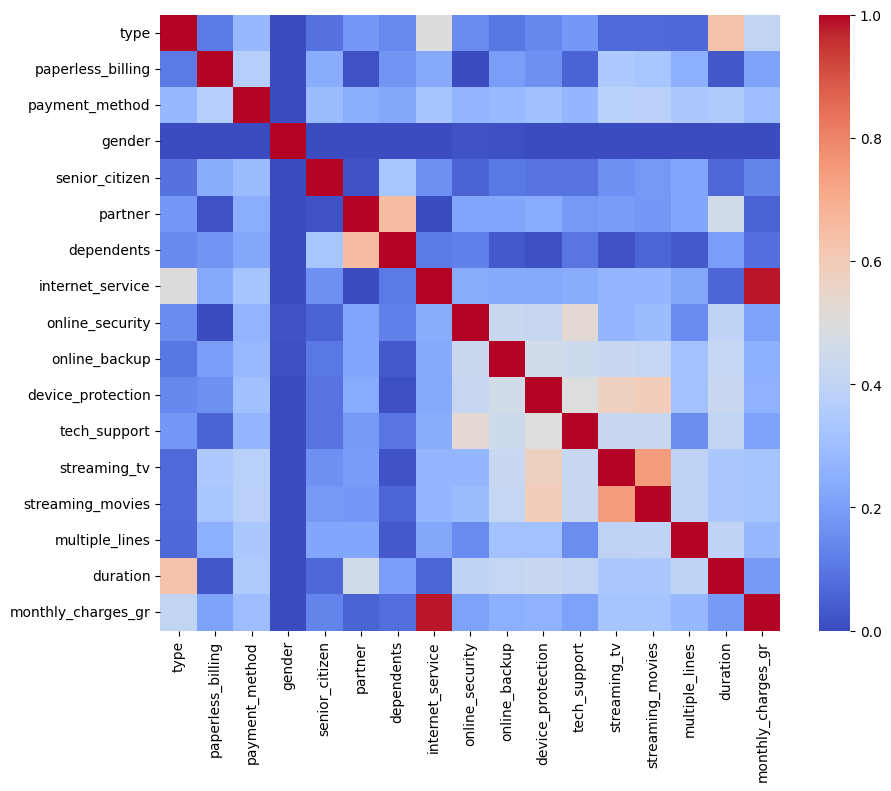

In [166]:
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix_2, cmap='coolwarm')
plt.show()

В оставшихся данных напрягает только очень сильная корреляция между типом интернета и месячной платой. Пока не знаю что с этим сделать.

Итак в исследовательском анализе была примерно показана разница между группой ушедших и оставшихся.

### Подготовка данных для обучения моделей

Непосредственно удалим из датафрейма ненужные признаки.

In [59]:
data_ml = data_full.drop(['monthly_charges', 'begin_date', 'end_date', 'total_charges', 'additional_services'], axis=1)

In [60]:
data_ml.head()

,type,paperless_billing,payment_method,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,refuse_the_service,duration,monthly_charges_gr
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31,1
5575-GNVDE,One year,No,Mailed check,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036,2
3668-QPYBK,Month-to-month,Yes,Mailed check,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123,2
7795-CFOCW,One year,No,Bank transfer (automatic),Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371,2
9237-HQITU,Month-to-month,Yes,Electronic check,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153,3


In [61]:
data_ml.columns

Index(['type', 'paperless_billing', 'payment_method', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines',
       'refuse_the_service', 'duration', 'monthly_charges_gr'],
      dtype='object')

In [62]:
# заменим все столбцы где данные бинарные и по типу Yes/No на 0 и 1, где 1-Yes
col_for_bin = ['paperless_billing', 'partner', 'dependents', 
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']
for i in col_for_bin:
    data_ml[i] = data_ml[i].replace(['Yes'], 1).replace(['No'], 0)

In [63]:
# gender тоже бинарный признак, заменим его на столбец male, где 1 - мужчина, 0 - не мужчина (соответственно женщина)
data_ml['male'] = data_ml['gender'].replace(['Female'], 0).replace(['Male'], 1)

In [64]:
# удалим gender
data_ml = data_ml.drop(['gender'], axis=1)

In [65]:
data_ml.head(5)

,type,paperless_billing,payment_method,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,refuse_the_service,duration,monthly_charges_gr,male
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,1,Electronic check,0,1,0,DSL,0,1,0,0,0,0,0,0,31,1,0
5575-GNVDE,One year,0,Mailed check,0,0,0,DSL,1,0,1,0,0,0,0,0,1036,2,1
3668-QPYBK,Month-to-month,1,Mailed check,0,0,0,DSL,1,1,0,0,0,0,0,0,123,2,1
7795-CFOCW,One year,0,Bank transfer (automatic),0,0,0,DSL,1,0,1,1,0,0,0,0,1371,2,1
9237-HQITU,Month-to-month,1,Electronic check,0,0,0,Fiber optic,0,0,0,0,0,0,0,0,153,3,0


**Разделим на выборки**

In [66]:
features = data_ml.drop(['refuse_the_service'], axis=1)
target = data_ml['refuse_the_service']

In [67]:
# делим на тренировочную и тестовую выборки с использованием stratify для о
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, test_size=0.25, random_state=RANDOM, stratify=target)

In [68]:
print(features_train.shape, target_train.shape, 
      features_test.shape, target_test.shape)

(5282, 17) (5282,) (1761, 17) (1761,)


In [69]:
print(f'Тренировочная: {target_train.value_counts(normalize=True)}')
print(f'Тестовая: {target_test.value_counts(normalize=True)}')

Тренировочная: refuse_the_service
0    0.84362
1    0.15638
Name: proportion, dtype: float64
Тестовая: refuse_the_service
0    0.843839
1    0.156161
Name: proportion, dtype: float64


Соотношение балансов почти одинаковое.\
Данные данные можно использовать для бустингов.

Теперь подготовлю данные для логистической регрессии и для всего остального.\
Для логистической регрессии категориальные небинарные данные закодирую с OHE, и проведу масштабирование.\
Для леса и бустингов просто закодирую категориальные небинарные OE.

In [70]:
features_train_lr = features_train.copy()
features_test_lr = features_test.copy()

In [71]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [72]:
col_for_ohe = ['type', 'payment_method', 'internet_service', 'monthly_charges_gr']

In [73]:
encoder_ohe.fit(features_train_lr[col_for_ohe])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

In [74]:
features_train_lr[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_lr[col_for_ohe])
features_train_lr = features_train_lr.drop(col_for_ohe, axis=1)

In [75]:
features_train_lr.head()

,paperless_billing,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration,male,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No,monthly_charges_gr_2,monthly_charges_gr_3
customerID,,,,,,,,,,,,,,,,,,,,,,
4452-ROHMO,0,0,0,0,0,0,0,0,0,0,0,457,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2885-HIJDH,0,0,1,1,1,0,1,1,1,1,1,2102,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0187-WZNAB,0,0,1,1,1,0,0,0,0,0,0,822,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
9184-GALIL,0,0,1,1,0,0,0,0,0,0,0,1157,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9779-DPNEJ,1,0,1,1,0,0,0,0,0,1,0,671,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [76]:
features_test_lr[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_lr[col_for_ohe])
features_test_lr = features_test_lr.drop(col_for_ohe, axis=1)

In [77]:
scaler = StandardScaler()
# Преобразуем 1D массив в 2D массив
duration_train_reshaped = features_train_lr['duration'].values.reshape(-1, 1)
duration_test_reshaped = features_test_lr['duration'].values.reshape(-1, 1)

# Применим StandardScaler к 2D массивам
features_train_lr['duration'] = scaler.fit_transform(duration_train_reshaped)
features_test_lr['duration'] = scaler.transform(duration_test_reshaped)

Данные для линейной регрессии готовы\
Сделаем для леса и бустинга.

In [78]:
features_train_rest = features_train.copy()
features_test_rest = features_test.copy()

In [79]:
col_for_oe = ['type', 'payment_method', 'internet_service']
encoder = OrdinalEncoder()
encoder.fit(features_train_rest[col_for_oe])
features_train_rest[
    encoder.get_feature_names_out()
] = encoder.transform(features_train_rest[col_for_oe])

In [80]:
features_test_rest[
    encoder.get_feature_names_out()
] = encoder.transform(features_test_rest[col_for_oe])

### Создание и обучение моделей

**Логистическая регрессия**

In [81]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [50, 100, 200]
}
model_lr = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=RANDOM),
                        param_grid = param_grid_lr, n_jobs=-1, cv = 5, scoring = 'roc_auc')
model_lr.fit(features_train_lr, target_train)
auc_lr_train = model_lr.best_score_
accuracy_lr = cross_val_score(model_lr.best_estimator_, features_train_lr, target_train, scoring='accuracy', cv=5).mean()
f1_lr = cross_val_score(model_lr.best_estimator_, features_train_lr, target_train, scoring='f1', cv=5).mean()
print('Лучшая метрика AUC на обучающей выборке:', auc_lr_train)
print('Метрика accuracy:', accuracy_lr)
print('Метрика f1 :', f1_lr)

Лучшая метрика AUC на обучающей выборке: 0.7534817727349506
Метрика accuracy: 0.6970836558584903
Метрика f1 : 0.4037833054113772


**Случайный лес**

In [82]:
param_grid_rf = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100, 1000], 
}
model_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=RANDOM),
                        param_grid = param_grid_rf, n_jobs=-1, cv = 5, scoring = 'roc_auc')
model_rf.fit(features_train_rest, target_train)
auc_rf_train = model_rf.best_score_
accuracy_rf = cross_val_score(model_rf.best_estimator_, features_train_rest, target_train, scoring='accuracy', cv=5).mean()
f1_rf = cross_val_score(model_rf.best_estimator_, features_train_rest, target_train, scoring='f1', cv=5).mean()
print('Лучшая метрика AUC на обучающей выборке:', auc_rf_train)
print('Метрика accuracy:', accuracy_rf)
print('Метрика f1 :', f1_rf)

Лучшая метрика AUC на обучающей выборке: 0.8312890765614774
Метрика accuracy: 0.7815189501447779
Метрика f1 : 0.48747664458759027


**Lightgbm**

In [83]:
param_grid_lgbm = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.1, 0.001],
    }
model_lgbm = GridSearchCV(lgb.LGBMClassifier(class_weight='balanced', random_state=RANDOM),
                        param_grid = param_grid_lgbm, n_jobs=-1, cv = 5, scoring = 'roc_auc')
model_lgbm.fit(features_train_rest, target_train)
auc_lgbm_train = model_lgbm.best_score_
accuracy_lgbm = cross_val_score(model_lgbm.best_estimator_, features_train_rest, target_train, scoring='accuracy', cv=5).mean()
f1_lgbm = cross_val_score(model_lgbm.best_estimator_, features_train_rest, target_train, scoring='f1', cv=5).mean()
print('Лучшая метрика AUC на обучающей выборке:', auc_lgbm_train)
print('Метрика accuracy:', accuracy_lgbm)
print('Метрика f1 :', f1_lgbm)

[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 223
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 661, number of negative: 3564
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 17
[LightGBM] [Info] [binary:Boos

**Catboost**

In [84]:
param_grid_catboost = {
    'iterations': [500],
    'learning_rate': [0.1],
    'depth': [6],
    'verbose': [100]
    }
cat_features = ['monthly_charges_gr']
model_cat = GridSearchCV(CatBoostClassifier(auto_class_weights='Balanced', random_state=RANDOM, cat_features=cat_features),
                        param_grid = param_grid_catboost, n_jobs=-1, cv = 5, scoring = 'roc_auc')
model_cat.fit(features_train_rest, target_train)
auc_cat_train = model_cat.best_score_
accuracy_cat = cross_val_score(model_cat.best_estimator_, features_train_rest, target_train, scoring='accuracy', cv=5).mean()
f1_cat = cross_val_score(model_cat.best_estimator_, features_train_rest, target_train, scoring='f1', cv=5).mean()
print('Лучшая метрика AUC на обучающей выборке:', auc_cat_train)
print('Метрика accuracy:', accuracy_cat)
print('Метрика f1 :', f1_cat)

0:	learn: 0.6546847	total: 84.6ms	remaining: 42.2s
100:	learn: 0.3923950	total: 1.29s	remaining: 5.08s
200:	learn: 0.2657280	total: 2.67s	remaining: 3.97s
300:	learn: 0.1981377	total: 4.05s	remaining: 2.68s
400:	learn: 0.1587629	total: 5.41s	remaining: 1.33s
499:	learn: 0.1308292	total: 6.73s	remaining: 0us
0:	learn: 0.6564778	total: 12.5ms	remaining: 6.24s
100:	learn: 0.3802643	total: 1.13s	remaining: 4.46s
200:	learn: 0.2506960	total: 2.44s	remaining: 3.62s
300:	learn: 0.1869572	total: 3.71s	remaining: 2.45s
400:	learn: 0.1484065	total: 4.99s	remaining: 1.23s
499:	learn: 0.1220752	total: 6.21s	remaining: 0us
0:	learn: 0.6551717	total: 12.2ms	remaining: 6.09s
100:	learn: 0.3884184	total: 1.18s	remaining: 4.67s
200:	learn: 0.2612176	total: 2.49s	remaining: 3.7s
300:	learn: 0.1945819	total: 3.78s	remaining: 2.5s
400:	learn: 0.1539572	total: 5.05s	remaining: 1.25s
499:	learn: 0.1224632	total: 6.3s	remaining: 0us
0:	learn: 0.6574244	total: 12.2ms	remaining: 6.07s
100:	learn: 0.3734269	tot

In [85]:
model_best = model_cat.best_estimator_

Метрика также достигнута.

Таблица сравнения:

In [86]:
data = [[auc_lr_train, accuracy_lr, f1_lr],
        [auc_rf_train, accuracy_rf, f1_rf],
        [auc_lgbm_train, accuracy_lgbm, f1_lgbm],
        [auc_cat_train, accuracy_cat, f1_cat]]
index = ['Логистическая регрессия', 'Случайный лес', 'Lgbm', 'Catboost']
df = pd.DataFrame(data=data, index=index, columns=['AUC-ROC', 'Accuracy', 'F-1'])
df

,AUC-ROC,Accuracy,F-1
Логистическая регрессия,0.753482,0.697084,0.403783
Случайный лес,0.831289,0.781519,0.487477
Lgbm,0.898680,0.895495,0.652013
Catboost,NaN,0.903633,0.707743


Лучшая модель по метрике AUC-ROC - Catboost. Её и проверим на тестовой выборке.

### Проверка лучшей модели

In [87]:
probabilities = model_cat.predict_proba(features_test_rest)[:, 1]
auc_roc = roc_auc_score(target_test, probabilities)

threshold = 0.5  # порог вероятности
predicted_labels = (probabilities > threshold).astype(int)
accuracy_test = accuracy_score(target_test, predicted_labels)
f1_test = f1_score(target_test, predicted_labels)
print("AUC-ROC на тестовой выборке:", auc_roc)
print('Accuracy на тестовой выборке:', accuracy_test)
print('F1 на тестовой выборке:', f1_test)
print(model_cat.best_params_)

AUC-ROC на тестовой выборке: 0.9189037073290102
Accuracy на тестовой выборке: 0.8824531516183987
F1 на тестовой выборке: 0.6600985221674878
{'depth': 6, 'iterations': 500, 'learning_rate': 0.1, 'verbose': 100}


Метрика AUC-ROC выше заданного минимума. Однако f1 и Accuracy заметно просели на тестовой выборке.

Нарисуем нашу красивую ROC-кривую

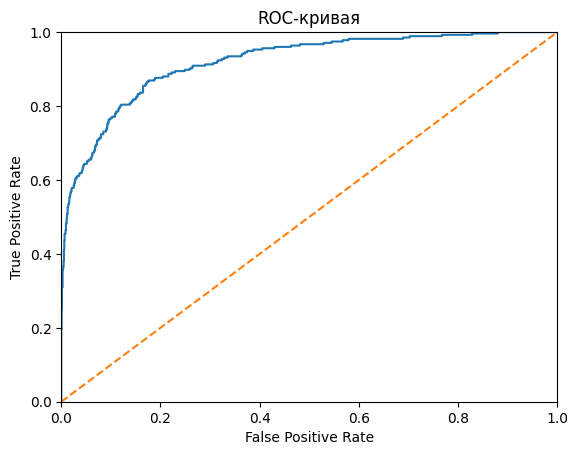

In [88]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities)
plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Посмотрим какие признаки влияют больше всего.

In [89]:
feature_importance = model_best.feature_importances_
feature_names = features_train_rest.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

In [90]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
14,duration,50.377737
0,type,7.422812
15,monthly_charges_gr,6.570721
2,payment_method,5.740072
6,internet_service,4.840720
4,partner,3.438179
13,multiple_lines,3.420134
12,streaming_movies,2.286064
16,male,2.144490
9,device_protection,2.045550


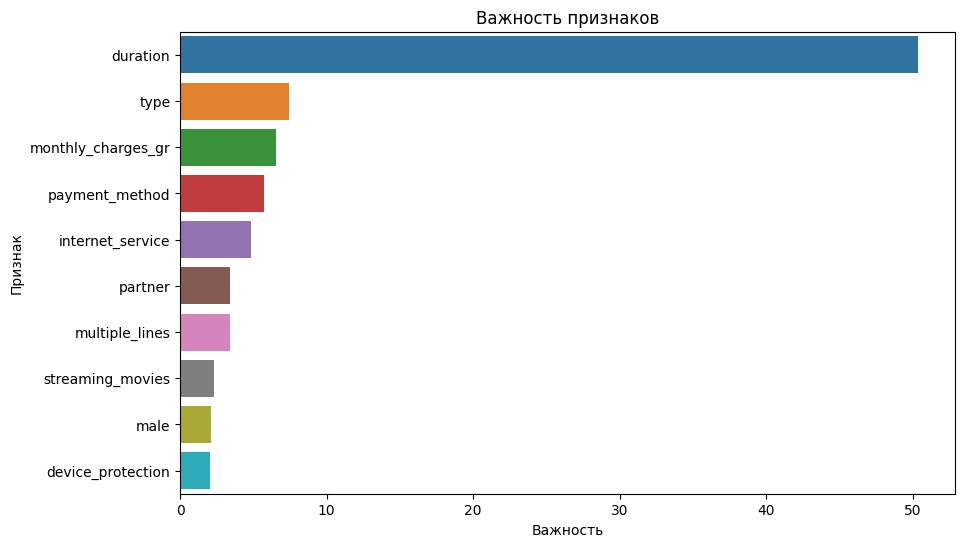

In [91]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df[:10]) 
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

**Промежуточные выводы:**\
Была проведена предобработка данных, а также исследовательский анализ данных.\
Данные были подготовлены для создания моделей: кодирование OHE и масштабирование для логистической регрессии и кодирование OE для случайного леса и бустингов. Для всех моделей в параметрах учитывался дисбаланс классов.\
На тренировочных данных лучшей моделью показал себя Catboost с метрикой AUC-ROC - 0.93 и высокими показателями метрик Accuracy (0.90) и F-1 (0.70).\
Данная модель также хорошо показала себя на тестовых данных с метрикой AUC-ROC - 0.92, Accuracy и f1 просели незначительно на тестовой выборке: 0.88 и 0.66 соответственно.\
Наиболее значимыми признаками для предиктивной модели оказались: длительность пользования услугами (с сильным отрывом от остальных) тип повременной оплаты, месячная стоимость услуг и способ оплаты.

## Отчет

Целью проета было разработать модель предсказывающую откажется ли конкретный клиент от услуг компании.\
Были предоставлены ретроспективные данные по клиентам в формате 4х датафремов.\
При первичном осмотре данных юыло опредедено, что их объединяет общий ключ - идентификатор клиента, следовательно их можно объединить в один датафрейм. Однако, сразу обратило на себя внимание отличающееся количество строк в таблицах, а также несоответствие некторорых столбцов нужным типа данных. Был составлен план работы.\
1. Предобработка данных.
- Установлена **константа RANDOM** = 250923. НАбор цифр соответствует дате начала финального проекта. Будет использоваться в моделях для получения одинаковых результатов в каждом выполнении кода (random_state).
- Данные объединены в один датафрейм по ключевому столбцу.
- Названия столбцов приведены к нижнему регистру
- Создан целевой признак на основании столбца "end_date". Где наличие даны соответствовало уходу клиента (1), а отсутствие - продолжение пользования услугами компании (0).
- Учитывая наличие данных о начале пользования услугами и данных о дате отказа, а так же известная дата актуальности данных, решено создать новый признак - длительность пользования услугами. Для этого в столбце "end_date" No заменены на дату актуальности данных.
- Обработаны пропуски. Т.к. пустые ячеки по смыслу соответствовали 
- Столбцы с датами приведены к соответствующему типу данных. Также приведен к правильному типу данных столбец с общими расходами, после обработки некорректных данных (знаки пробела в некоторых ячейках заменены на месячный расход, т.к. они соответствовали новым клиентам).
- Добавлены два новых признака: первый, вышеописанный - длительность пользования в днях (дата окончания за вычетом даты начала пользования). Второй - количество подключенных услуг. Первый признак также является целевим для наших будующих моделей. Сразу отмечен дисбаланс этого признака - отказавшихся от услуг чуть больше 15 процентов.\
Произведена предобработка данных. Данные готовы к исследовательскому анализу.
2. Исследовательский анализ данных.
- Дана характеристика среднего клиента по датафрейму: работающий человек без иждивенцов, предпочитающий помесячную оплату электронным чеком с подключеными 2-3 дополнительными услугами. С примерно одинаковой частотой состоящие в браке или нет. Средняя продолжительность пользования услугами порядка 900 дней
- Приведено сравнение группы людей отказавшихся от услуг и продолжающих пользоваться услугами компании: Можно отметить, что в группах сохраняется примерно одинаковое соотношение женщин и мужчин, предпочтение безналичному расчету и преимущественно отсутствие иждивенцов.\
В отличие от оставшихся у ушедших нет сильного превалирования помесячной оплаты и типа оплаты - электронного чека. У ушедших более вероятно есть супруг, и количество используемых дополнительных услуг больше.
- Рассмотрена мультиколлинеарность признаков. Здесь возникла первая проблема: интерпретация и решение об удалении или сохранении признаков.\
Вначале были рассмотрены все имеющиеся признаки без целевого. Выявлена сильная зависимость даты начала и длительности - не проблема, т.к. дата начала и конца пользования услугами планируется к удалению после исследовательского анализа. Так же ненадежными признаками показались месячные траты, общие траты, и новый признак - количество доп. услуг. Принято решение оценить мультиколинеарность без данных признаков и с добавлением нового признака - месячные траты разбиты на три группы по величине трат. Результат удовлетворительный, кроме очень очень высокой корреляции у группы месячных трат и типом подключенного интернета. Решено оставить такой вариант набора признаков, т.к. наибольшее значением это имеет для линейных модолей. По метрикам можно будет примерно оценить происходит ли утечка и в случае чего поправить еще раз набор признаков. Для бустингов данная высокая корреляция не должна быть проблемой.
3. Подготовка данных непосредственно для моделей.
- Удалены признаки определенные выше при анализе мультиколинеарности.\
**Остались следующие признаки, которые использовались для обучения моделей:** Категориальные небинарные: тип оплаты, способ оплаты, тип интернет подключения, группа месячных расходов. Категориальные бинарные: безналичный расчет, гендер, пенсионер, брак, иждивенцы, все виды дополнительных интернет и телефонных услуг. Непрерывные данные: длительность пользования услугами в днях. Естественно оставлен целевой признак - факт отказа от услуг.
- Бинарные признаки переведены в числовой вариант.
- Датасет поделен на тренировочную и тестовую выборки (с сохраненим пропорции дисбаланса целевого признака), а также отделен целевой признак.
- Данные подготовлены для двух типо моделей: для линейных моделей (логистической регрессии) и для остальных.\
Для логистической регрессии категориальные небинарные данные закодированы с помощью OHE, и проведено масштабирование.\
Для леса и бустингов категориальные небинарные признаки закодированы OE.
4. Обучение моделей\
Выбраны 4 модели для обучения: логистическая регрессия, случайный лес и две бустинговые модели: LGBM и Catboost. Помимо обязательной метрики AUC-ROC также выбраны две дополнительные метрики accuracy и f1 мера.\
В результате обучения моделей был достигнут AUC-ROC  выше минимальнотребуемого 0.85 в двух бустинговых моделях.

| Модель                   | AUC-ROC  | Accuracy  | F-1      |
|--------------------------|----------|-----------|----------|
| Логистическая регрессия  | 0.753482 | 0.697084  | 0.403783 |
| Случайный лес            | 0.831289 | 0.781519  | 0.487477 |
| Lgbm                     | 0.898680 | 0.895495  | 0.652013 |
| Catboost                 | 0.926960 | 0.903633  | 0.707743 |

C учетом дополнительных метрик лучшей моделью выбран Catboost  со следующими **гиперпараметрами:** 'depth': 6, 'iterations': 500, 'learning_rate': 0.1.\
'depth': 6 - глубина деревьев в CatBoost. Каждый узел дерева представляет собой разделение по одному из признаков, и глубина определяет, насколько глубоко дерево может делиться на узлы.\
'iterations': 500 - количество итераций, которые CatBoost будет строить. Чем больше итераций, тем больше шансов у модели выучить сложные закономерности в данных.\
'learning_rate': 0.1 - этот параметр определяет размер шага при обучении модели. Он контролирует, насколько быстро модель учится. Низкий learning rate может увеличить точность модели, но потребует большего числа итераций для обучения.\
Таким образом удалось добиться следующих результатов метрик на тренировочной выборке: AUC-ROC - 0.92, Accuracy - 0.90, F-1 - 0.70.\
\
5. Проверка на тестовой модели.
- В результате проверки на тестовой выборке получены следующие результаты: AUC-ROC - 0.918, Accuracy - 0.88, F-1 - 0.66. Результат удовлетворителен.\
Для визуализации построена ROC-кривая.
- Определено какие признаки больше всего влияли на результат: длительность пользования услугами (с сильным отрывом от остальных) тип повременной оплаты, месячная стоимость услуг и способ оплаты.

Все этапы выполнения проекта являются значимыми. Трудно себе представить разработку адекватной предиктивной модели без предобработки данных, оценки их валидности для использования в машинном обучении и адекватного преобразования имеющихся данных для моделей. Так же выбор модели в реальных условиях будет зависеть от многих факторов и не всегда лучшие показатели метрик будут определять выбор модели.